# 📘 DLinear Algorithm 

**DLinear (Decomposition-Linear)** is a neural network (NN) model designed for **time-series forecasting**.  
It is based on a **series decomposition** idea:

\[
x(t) = \text{trend}(t) + \text{seasonal}(t)
\]

The input sequence is split into **trend** and **seasonal** components.

- A **linear layer** is trained to predict the **trend**.  
- Another **linear layer** predicts the **seasonality**.  
- The **final forecast** is the sum of **trend + seasonal forecasts**.

### ✅ Key Advantages:
- ✔ **Simple**: Uses only linear layers (no RNNs or Transformers).  
- ✔ **Fast & Efficient**: Lightweight model architecture.  
- ✔ **Competitive Accuracy**: Performs well compared to deep models.  

---

# 📘 Parameters Used in the Code

From `DLinear_MultiCategory_Forecast.ipynb`, here are the main parameters:

## 🔹 Model Parameters
| Parameter      | Value | Description |
|----------------|-------|-------------|
| `seq_len`      | 30    | Number of past time steps given as input. |
| `pred_len`     | 7     | Forecast horizon (future steps to predict). |
| `enc_in`       | 8     | Number of input features (8 drug categories). |
| `individual`   | False | Shared linear layers for all features. |

---

## 🔹 Training Parameters
| Parameter        | Value  | Description |
|------------------|--------|-------------|
| `batch_size`     | 32     | Sequences per batch during training. |
| `learning_rate`  | 0.001  | Optimizer step size. |
| `epochs`         | 50     | Full dataset training iterations. |
| `loss`           | MSELoss | Mean Squared Error for error calculation. |
| `optimizer`      | Adam   | Adaptive optimizer for weight updates. |

---

## 🔹 Data Parameters
| Parameter                | Value           | Description |
|--------------------------|----------------|-------------|
| `train/val/test split`   | 70% / 15% / 15% | Dataset partitioning. |
| `scaling`                | StandardScaler | Normalizes data before training. |

---



# DLinear Multi-Category Time Series Forecasting

This notebook trains a simple **DLinear** model for **8 categories**:
`['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']`.

It will:
- Load and prepare data (with optional smoothing and scaling).
- Train one DLinear per category.
- Perform a rolling forecast evaluation.
- Generate next-step forecasts.
- Save metrics, models, and plots.




## 1) Imports

In [10]:

import os
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Ensure reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Matplotlib defaults (no explicit colors to keep things simple)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True


## 2) Configuration

In [11]:

# Path to your CSV
# For this environment, the file is available at /mnt/data/holidays.csv.
# Change this if your file lives elsewhere.
DATA_PATH = r"D:\HACH_cts\dataset\salesweekly.csv"

# Name of the datetime column in your dataset
DATE_COL = "datum"

# The 8 categories to model
CATEGORIES = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']

# Optional smoothing
SMOOTH_WINDOW = 3  # moving average window (set to 1 to disable smoothing)

# DLinear hyperparameters
INPUT_LEN = 48          # lookback window length
PRED_LEN = 4            # forecast horizon
EPOCHS = 100
LR = 0.005
BATCH_SIZE = 32

# Evaluation will be done on the test portion (last 20% of the series)
TEST_FRACTION = 0.2

# Output directories
OUT_DIR = "D:\HACH_cts\Dlinerar_model"
MODEL_DIR = os.path.join(OUT_DIR, "models")
PLOTS_DIR = os.path.join(OUT_DIR, "plots")
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


<>:26: SyntaxWarning: invalid escape sequence '\H'
<>:26: SyntaxWarning: invalid escape sequence '\H'
C:\Users\balaj\AppData\Local\Temp\ipykernel_2408\1481230106.py:26: SyntaxWarning: invalid escape sequence '\H'
  OUT_DIR = "D:\HACH_cts\Dlinerar_model"


'cpu'

## 3) Load & Inspect Data

In [12]:

df = pd.read_csv(DATA_PATH)
if DATE_COL not in df.columns:
    raise ValueError(f"Expected a datetime column named '{DATE_COL}' in the CSV. Found columns: {df.columns.tolist()}")

df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors='coerce')
df = df.dropna(subset=[DATE_COL]).sort_values(DATE_COL).reset_index(drop=True)

# Basic cleaning for the 8 categories: coerce to numeric and fill short gaps
for col in CATEGORIES:
    if col not in df.columns:
        raise ValueError(f"Missing expected category column: {col}")
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].interpolate(limit_direction="both").fillna(0)

# Quick peek
display(df[[DATE_COL] + CATEGORIES].head())
display(df[[DATE_COL] + CATEGORIES].tail())
print("Rows:", len(df))


,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,2014-01-05,14.00,11.67,21.3,185.95,41.0,0.0,32.0,7.0
1,2014-01-12,29.33,12.68,37.9,190.70,88.0,5.0,21.0,7.2
2,2014-01-19,30.67,26.34,45.9,218.40,80.0,8.0,29.0,12.0
3,2014-01-26,34.00,32.37,31.5,179.60,80.0,8.0,23.0,10.0
4,2014-02-02,31.02,23.35,20.7,159.88,84.0,12.0,29.0,12.0


,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
297,2019-09-15,35.51,30.977,19.65,178.375,67.2,5.0,30.000000,30.50
298,2019-09-22,46.84,25.396,24.40,248.250,31.2,3.0,26.000000,21.00
299,2019-09-29,34.01,22.498,26.60,336.700,61.2,1.0,40.416667,23.10
300,2019-10-06,38.70,32.502,19.25,249.450,69.0,5.0,30.000000,12.13
301,2019-10-13,7.67,6.237,3.50,95.100,26.0,2.0,12.000000,1.00


Rows: 302


## 4) Dataset & DLinear Model

In [13]:

class TimeSeriesDataset(Dataset):
    """
    Creates (x, y) pairs from a 1D series:
      x: past INPUT_LEN values
      y: next PRED_LEN values
    """
    def __init__(self, series, input_len=24, pred_len=4):
        self.series = np.asarray(series, dtype=np.float32)
        self.input_len = input_len
        self.pred_len = pred_len

    def __len__(self):
        return max(0, len(self.series) - self.input_len - self.pred_len + 1)

    def __getitem__(self, idx):
        x = self.series[idx: idx + self.input_len]
        y = self.series[idx + self.input_len: idx + self.input_len + self.pred_len]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


class DLinear(nn.Module):
    """
    Minimal DLinear-style model with separate linear layers for trend & seasonal
    (Here we do not explicitly decompose; it's a simple 2-branch linear structure.)
    """
    def __init__(self, input_len, pred_len):
        super().__init__()
        self.linear_trend = nn.Linear(input_len, pred_len)
        self.linear_seasonal = nn.Linear(input_len, pred_len)

    def forward(self, x):
        # x: (batch, input_len)
        trend = self.linear_trend(x)
        seasonal = self.linear_seasonal(x)
        return trend + seasonal


## 5) Training, Forecasting & Evaluation Helpers

In [14]:

def safe_mape(y_true, y_pred, epsilon=1e-8):
    y_true = np.asarray(y_true, dtype=np.float64)
    y_pred = np.asarray(y_pred, dtype=np.float64)
    denom = np.where(np.abs(y_true) < epsilon, np.nan, np.abs(y_true))
    mape_vals = np.abs((y_true - y_pred) / denom)
    return np.nanmean(mape_vals) * 100.0

def train_dlinear(series, input_len=24, pred_len=4, epochs=100, lr=0.005, batch_size=32, device="cpu", verbose_every=20):
    dataset = TimeSeriesDataset(series, input_len, pred_len)
    if len(dataset) == 0:
        raise ValueError("Not enough data to create training samples. Increase data or decrease INPUT_LEN/PRED_LEN.")
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False)

    model = DLinear(input_len, pred_len).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if verbose_every and epoch % verbose_every == 0:
            print(f"Epoch {epoch:3d} | Loss: {total_loss/len(loader):.6f}")
    return model

@torch.no_grad()
def forecast_dlinear(model, series, input_len=24, pred_len=4, device="cpu"):
    model.eval()
    arr = np.asarray(series, dtype=np.float32)
    if len(arr) < input_len:
        raise ValueError("Series shorter than input_len; cannot forecast.")
    last_input = torch.tensor(arr[-input_len:], dtype=torch.float32).unsqueeze(0).to(device)  # (1, input_len)
    forecast = model(last_input).detach().cpu().numpy().flatten()
    return forecast

def rolling_forecast_eval(model, series_scaled, input_len, pred_len, scaler, start_index=None):
    """
    Rolling evaluation **on scaled series**, inverse-transforming for metrics.
    By default, evaluates on the last 20% (test split). You can override start_index.
    """
    n = len(series_scaled)
    if start_index is None:
        # default start so that we evaluate *mostly* on test region
        start_index = int(n * (1 - TEST_FRACTION)) - input_len
        start_index = max(input_len, start_index)

    mse_list, rmse_list, mape_list = [], [], []

    for i in range(start_index, n - pred_len):
        window = series_scaled[i - input_len : i + pred_len]       # length input_len + pred_len
        if len(window) < input_len + pred_len:
            continue
        input_seq = window[:input_len]
        true_scaled = window[input_len:input_len + pred_len]

        # Forecast using exactly this window's input
        forecast_scaled = forecast_dlinear(model, input_seq, input_len, pred_len, device=DEVICE)
        forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()
        true = scaler.inverse_transform(true_scaled.reshape(-1, 1)).flatten()

        mse = mean_squared_error(true, forecast)
        rmse = math.sqrt(mse)
        mape = safe_mape(true, forecast)

        mse_list.append(mse)
        rmse_list.append(rmse)
        mape_list.append(mape)

    if len(mse_list) == 0:
        return float("nan"), float("nan"), float("nan")
    return float(np.mean(mse_list)), float(np.mean(rmse_list)), float(np.mean(mape_list))


## 6) Train & Evaluate Across All 8 Categories


===== Category: M01AB =====
Epoch  20 | Loss: 0.018257
Epoch  40 | Loss: 0.014395
Epoch  60 | Loss: 0.014540
Epoch  80 | Loss: 0.011889
Epoch 100 | Loss: 0.011309
MSE: 19.2257 | RMSE: 3.9764 | MAPE: 9.89%


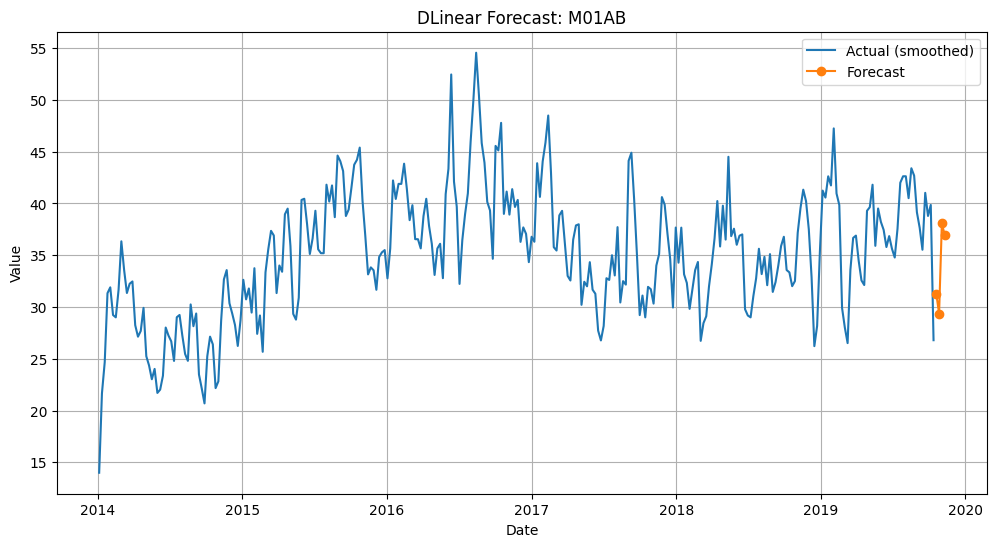


===== Category: M01AE =====
Epoch  20 | Loss: 0.011467
Epoch  40 | Loss: 0.009482
Epoch  60 | Loss: 0.008604
Epoch  80 | Loss: 0.007858
Epoch 100 | Loss: 0.007648
MSE: 34.8673 | RMSE: 4.8154 | MAPE: 16.34%


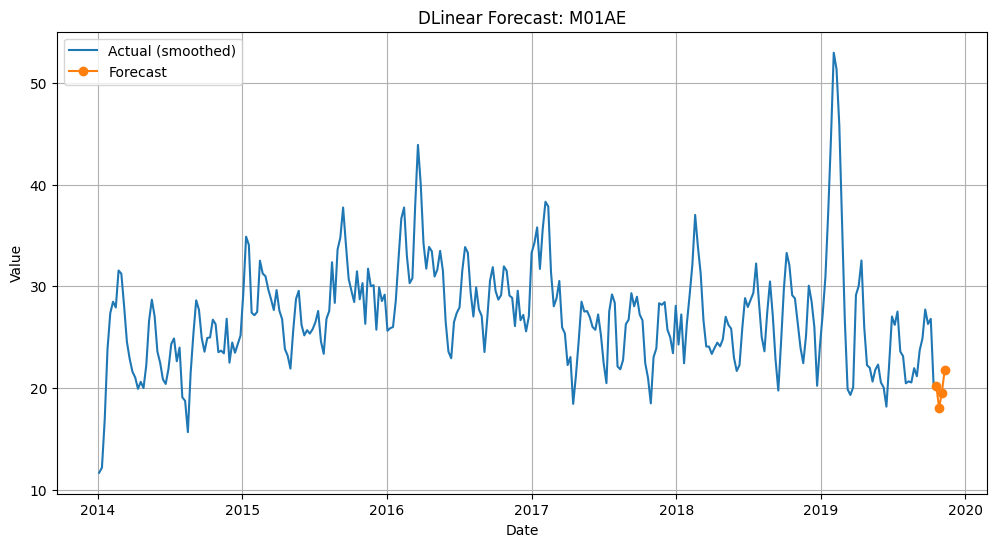


===== Category: N02BA =====
Epoch  20 | Loss: 0.019055
Epoch  40 | Loss: 0.016335
Epoch  60 | Loss: 0.014140
Epoch  80 | Loss: 0.013764
Epoch 100 | Loss: 0.013239
MSE: 9.8937 | RMSE: 2.8590 | MAPE: 11.89%


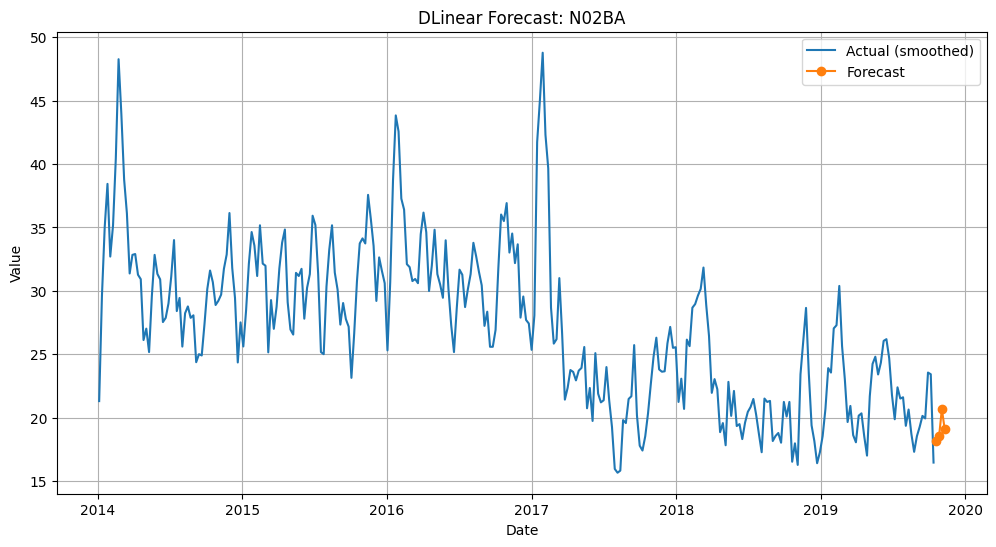


===== Category: N02BE =====
Epoch  20 | Loss: 0.018362
Epoch  40 | Loss: 0.014864
Epoch  60 | Loss: 0.013883
Epoch  80 | Loss: 0.013865
Epoch 100 | Loss: 0.012692
MSE: 1363.5064 | RMSE: 31.8234 | MAPE: 14.12%


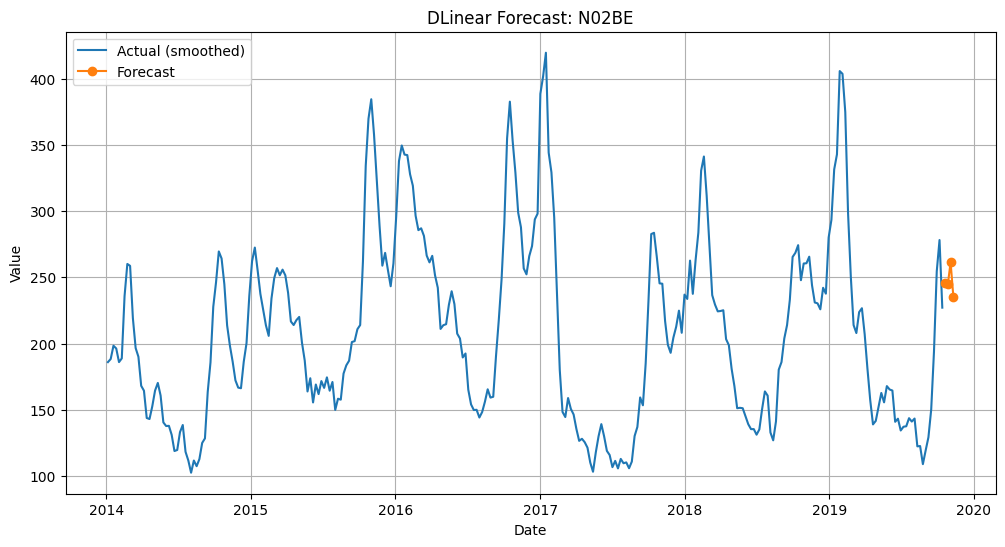


===== Category: N05B =====
Epoch  20 | Loss: 0.020629
Epoch  40 | Loss: 0.016240
Epoch  60 | Loss: 0.015173
Epoch  80 | Loss: 0.015077
Epoch 100 | Loss: 0.014464
MSE: 71.2276 | RMSE: 7.4147 | MAPE: 10.79%


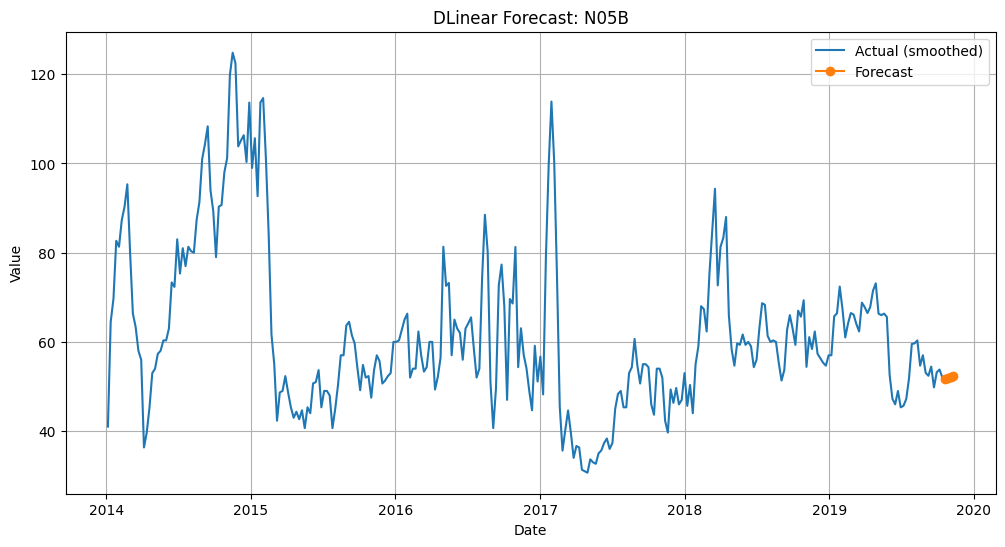


===== Category: N05C =====
Epoch  20 | Loss: 0.022248
Epoch  40 | Loss: 0.020021
Epoch  60 | Loss: 0.017845
Epoch  80 | Loss: 0.019644
Epoch 100 | Loss: 0.017300
MSE: 4.0644 | RMSE: 1.6923 | MAPE: 39.81%


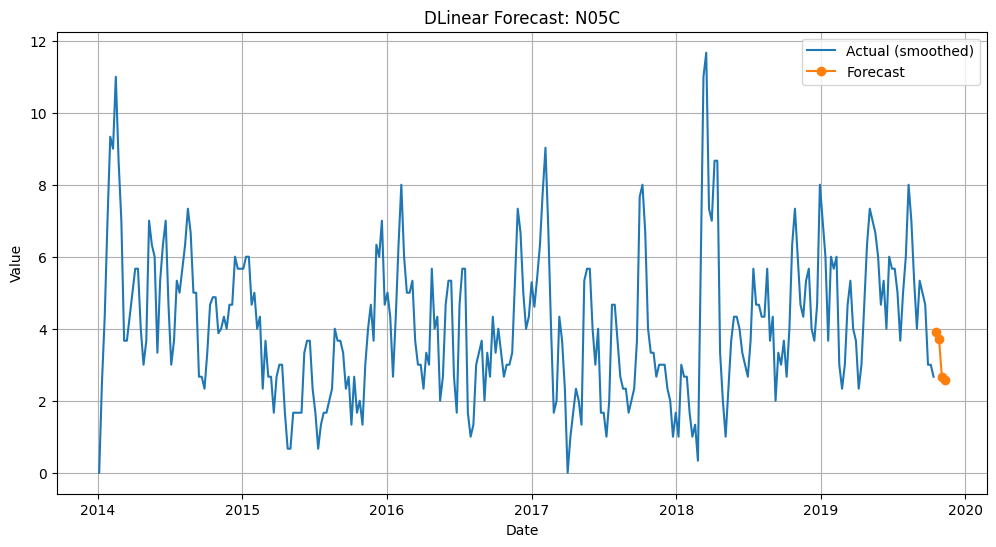


===== Category: R03 =====
Epoch  20 | Loss: 0.007967
Epoch  40 | Loss: 0.007725
Epoch  60 | Loss: 0.007302
Epoch  80 | Loss: 0.007524
Epoch 100 | Loss: 0.006819
MSE: 274.0523 | RMSE: 13.4526 | MAPE: 27.18%


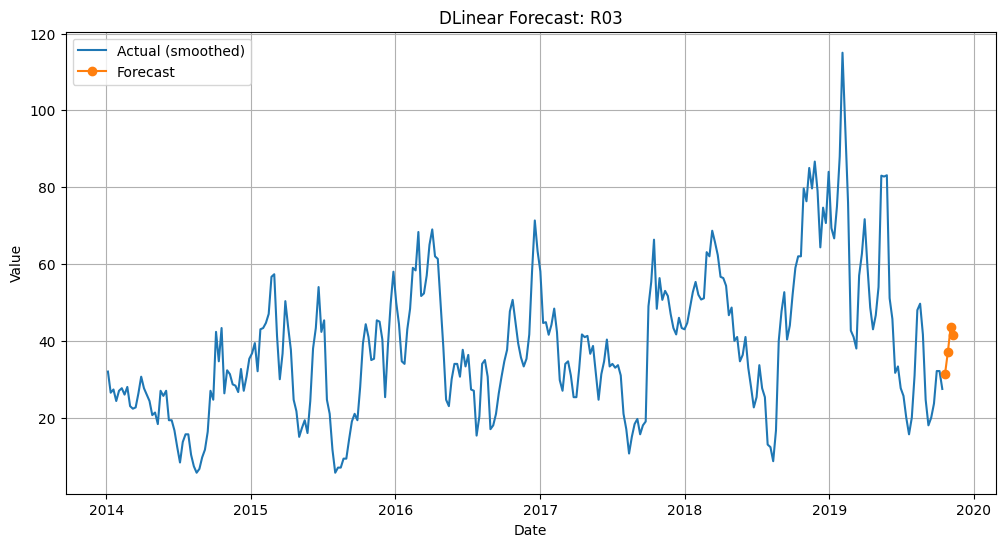


===== Category: R06 =====
Epoch  20 | Loss: 0.008020
Epoch  40 | Loss: 0.006863
Epoch  60 | Loss: 0.006437
Epoch  80 | Loss: 0.005987
Epoch 100 | Loss: 0.005708
MSE: 22.1653 | RMSE: 4.0441 | MAPE: 19.78%


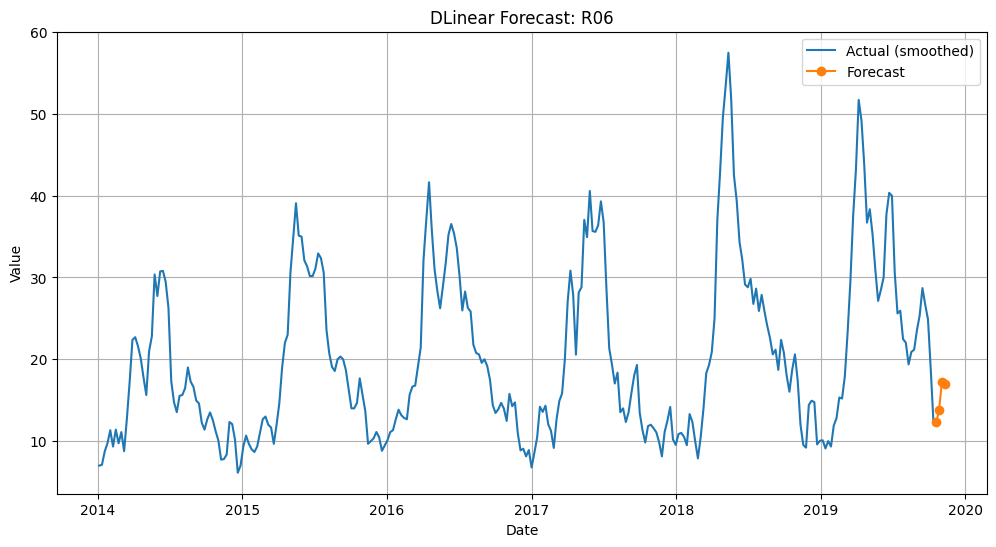

,Category,MSE,RMSE,MAPE_%
0,M01AB,19.225712,3.976405,9.886884
1,M01AE,34.867277,4.815416,16.340049
2,N02BA,9.893737,2.859039,11.893234
3,N02BE,1363.506388,31.823379,14.124334
4,N05B,71.227618,7.414719,10.786310
5,N05C,4.064370,1.692263,39.808146
6,R03,274.052253,13.452642,27.177942
7,R06,22.165343,4.044070,19.775181


Saved metrics to: D:\HACH_cts\Dlinerar_model\dlinear_metrics.csv


In [15]:

metrics = []
all_forecasts = {}

for col in CATEGORIES:
    print(f"\n===== Category: {col} =====")
    series_raw = df[col].astype(float).values

    # Optional smoothing
    if SMOOTH_WINDOW and SMOOTH_WINDOW > 1:
        series_proc = pd.Series(series_raw).rolling(SMOOTH_WINDOW, min_periods=1).mean().values
    else:
        series_proc = series_raw.copy()

    # Scaling
    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series_proc.reshape(-1, 1)).flatten()

    # Train/Test split
    split_idx = int(len(series_scaled) * (1 - TEST_FRACTION))
    train_series = series_scaled[:split_idx]
    test_series = series_scaled[split_idx:]

    # Train model on training portion only
    try:
        model = train_dlinear(
            train_series,
            input_len=INPUT_LEN,
            pred_len=PRED_LEN,
            epochs=EPOCHS,
            lr=LR,
            batch_size=BATCH_SIZE,
            device=DEVICE,
            verbose_every=20
        )
    except ValueError as e:
        print(f"Skipping {col} due to error: {e}")
        continue

    # Save model
    torch.save(model.state_dict(), os.path.join(MODEL_DIR, f"DLinear_{col}.pt"))

    # Rolling evaluation on (mostly) test region
    mse, rmse, mape = rolling_forecast_eval(model, series_scaled, INPUT_LEN, PRED_LEN, scaler)
    print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAPE: {mape:.2f}%")

    # Forecast next PRED_LEN steps from full series
    forecast_scaled = forecast_dlinear(model, series_scaled, INPUT_LEN, PRED_LEN, device=DEVICE)
    forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()
    all_forecasts[col] = forecast

    # Plot and save
    future_dates = pd.date_range(start=df[DATE_COL].iloc[-1] + pd.Timedelta(weeks=1), periods=PRED_LEN, freq="W")
    plt.figure()
    plt.plot(df[DATE_COL], series_proc, label="Actual (smoothed)")
    plt.plot(future_dates, forecast, label="Forecast", marker="o")
    plt.title(f"DLinear Forecast: {col}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plot_path = os.path.join(PLOTS_DIR, f"{col}_forecast.png")
    plt.savefig(plot_path, bbox_inches="tight")
    plt.show()

    metrics.append({
        "Category": col,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE_%": mape
    })

metrics_df = pd.DataFrame(metrics).sort_values("Category").reset_index(drop=True)
display(metrics_df)

# Save metrics to CSV
metrics_csv = os.path.join(OUT_DIR, "dlinear_metrics.csv")
metrics_df.to_csv(metrics_csv, index=False)
print("Saved metrics to:", metrics_csv)


## 7) Where to Find Outputs

In [ ]:

from pathlib import Path

print("Model files:")
for p in Path(MODEL_DIR).glob("*.pt"):
    print(" -", p)

print("\nForecast plots:")
for p in Path(PLOTS_DIR).glob("*.png"):
    print(" -", p)

print("\nMetrics CSV:")
print(os.path.join(OUT_DIR, "dlinear_metrics.csv"))


Model files:
 - D:\HACH_cts\Dlinerar_model\models\DLinear_M01AB.pt
 - D:\HACH_cts\Dlinerar_model\models\DLinear_M01AE.pt
 - D:\HACH_cts\Dlinerar_model\models\DLinear_N02BA.pt
 - D:\HACH_cts\Dlinerar_model\models\DLinear_N02BE.pt
 - D:\HACH_cts\Dlinerar_model\models\DLinear_N05B.pt
 - D:\HACH_cts\Dlinerar_model\models\DLinear_N05C.pt
 - D:\HACH_cts\Dlinerar_model\models\DLinear_R03.pt
 - D:\HACH_cts\Dlinerar_model\models\DLinear_R06.pt

Forecast plots:
 - D:\HACH_cts\Dlinerar_model\plots\M01AB_forecast.png
 - D:\HACH_cts\Dlinerar_model\plots\M01AE_forecast.png
 - D:\HACH_cts\Dlinerar_model\plots\N02BA_forecast.png
 - D:\HACH_cts\Dlinerar_model\plots\N02BE_forecast.png
 - D:\HACH_cts\Dlinerar_model\plots\N05B_forecast.png
 - D:\HACH_cts\Dlinerar_model\plots\N05C_forecast.png
 - D:\HACH_cts\Dlinerar_model\plots\R03_forecast.png
 - D:\HACH_cts\Dlinerar_model\plots\R06_forecast.png

Metrics CSV:
D:\HACH_cts\Dlinerar_model\dlinear_metrics.csv


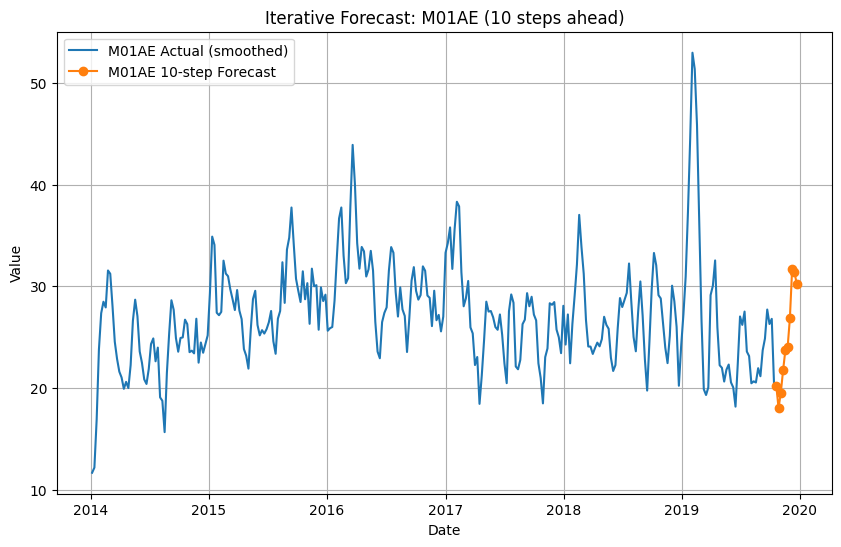


Forecasted Values:

      Date  M01AE Forecast
2019-10-20       20.241138
2019-10-27       18.019474
2019-11-03       19.545103
2019-11-10       21.738026
2019-11-17       23.698282
2019-11-24       23.991909
2019-12-01       26.840347
2019-12-08       31.722908
2019-12-15       31.424263
2019-12-22       30.250982


In [9]:
def iterative_forecast(model, series_scaled, scaler, input_len, step_size, total_steps, device="cpu"):
    """
    Iteratively forecast total_steps ahead using a model trained with step_size (e.g. 4).
    """
    model.eval()
    history = series_scaled.copy()
    forecasts = []

    while len(forecasts) < total_steps:
        last_input = torch.tensor(history[-input_len:], dtype=torch.float32).unsqueeze(0).to(device)
        step_forecast = model(last_input).detach().cpu().numpy().flatten()
        step_forecast = step_forecast[:min(step_size, total_steps - len(forecasts))]  # cut if overshoot
        forecasts.extend(step_forecast)
        history = np.concatenate([history, step_forecast])  # append preds to history

    # Inverse scale
    forecasts = scaler.inverse_transform(np.array(forecasts).reshape(-1, 1)).flatten()
    return forecasts


# Example usage
n_steps = 10   # forecast 10 steps ahead
example_col = CATEGORIES[1]

# Reload trained model (still PRED_LEN=4)
reloaded = DLinear(INPUT_LEN, 4).to(DEVICE)
reloaded.load_state_dict(torch.load(os.path.join(MODEL_DIR, f"DLinear_{example_col}.pt"), map_location=DEVICE))
reloaded.eval()

# Recompute scaler
series_raw = df[example_col].astype(float).values
series_proc = pd.Series(series_raw).rolling(SMOOTH_WINDOW, min_periods=1).mean().values if SMOOTH_WINDOW > 1 else series_raw
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series_proc.reshape(-1, 1)).flatten()

# Iterative forecast
forecast = iterative_forecast(reloaded, series_scaled, scaler, INPUT_LEN, step_size=4, total_steps=n_steps)

# Dates for plotting
future_dates = pd.date_range(start=df[DATE_COL].iloc[-1] + pd.Timedelta(weeks=1), periods=n_steps, freq="W")

# --- Plot Forecast ---
plt.figure(figsize=(10, 6))
plt.plot(df[DATE_COL], series_proc, label=f"{example_col} Actual (smoothed)")
plt.plot(future_dates, forecast, label=f"{example_col} {n_steps}-step Forecast", marker="o")
plt.title(f"Iterative Forecast: {example_col} ({n_steps} steps ahead)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# --- Display Forecast Table ---
forecast_df = pd.DataFrame({
    "Date": future_dates,
    f"{example_col} Forecast": forecast
})

print("\nForecasted Values:\n")
print(forecast_df.to_string(index=False))


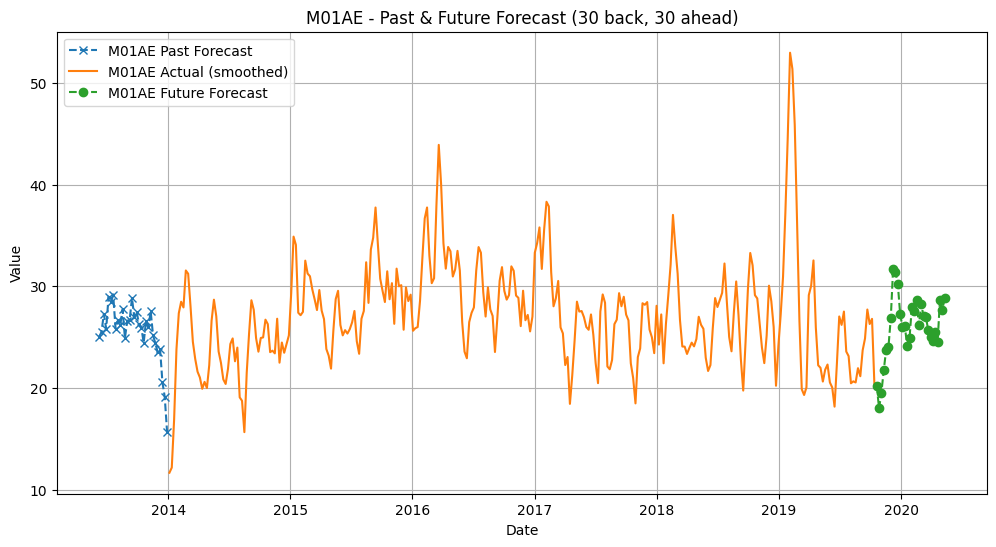


Full Forecasted Values:

      Date  M01AE Forecast/Actual
2013-06-09              24.981598
2013-06-16              25.533886
2013-06-23              27.272875
2013-06-30              25.815851
2013-07-07              28.991089
2013-07-14              28.484320
2013-07-21              29.094126
2013-07-28              25.819780
2013-08-04              26.637794
2013-08-11              26.175797
2013-08-18              27.719095
2013-08-25              24.904419
2013-09-01              26.623615
2013-09-08              26.650349
2013-09-15              28.830593
2013-09-22              26.993414
2013-09-29              27.511803
2013-10-06              26.257936
2013-10-13              25.942898
2013-10-20              24.439289
2013-10-27              26.576029
2013-11-03              25.986900
2013-11-10              27.523298
2013-11-17              25.173140
2013-11-24              24.393223
2013-12-01              23.495888
2013-12-08              23.836634
2013-12-15            

In [16]:
def iterative_forecast_both(model, series_scaled, scaler, input_len, step_size, past_steps, future_steps, device="cpu"):
    """
    Forecast both past and future values using an iterative model.
    
    - past_steps: number of steps to forecast backward
    - future_steps: number of steps to forecast forward
    """
    model.eval()
    history = series_scaled.copy()

    # ---------------- FUTURE FORECAST ----------------
    future_forecasts = []
    future_history = history.copy()
    
    while len(future_forecasts) < future_steps:
        last_input = torch.tensor(future_history[-input_len:], dtype=torch.float32).unsqueeze(0).to(device)
        step_forecast = model(last_input).detach().cpu().numpy().flatten()
        step_forecast = step_forecast[:min(step_size, future_steps - len(future_forecasts))]
        future_forecasts.extend(step_forecast)
        future_history = np.concatenate([future_history, step_forecast])

    # ---------------- PAST FORECAST ----------------
    past_forecasts = []
    past_history = history.copy()
    
    while len(past_forecasts) < past_steps:
        first_input = torch.tensor(past_history[:input_len], dtype=torch.float32).flip(0).unsqueeze(0).to(device)
        step_forecast = model(first_input).detach().cpu().numpy().flatten()
        step_forecast = step_forecast[:min(step_size, past_steps - len(past_forecasts))]
        past_forecasts.extend(step_forecast)
        past_history = np.concatenate([step_forecast[::-1], past_history])

    # Inverse scaling
    future_forecasts = scaler.inverse_transform(np.array(future_forecasts).reshape(-1, 1)).flatten()
    past_forecasts = scaler.inverse_transform(np.array(past_forecasts).reshape(-1, 1)).flatten()

    return past_forecasts[::-1], future_forecasts


# --- Parameters ---
n_future = 30  # Forecast 30 steps ahead
n_past = 30    # Forecast 30 steps backward
example_col = CATEGORIES[1]

# Reload trained model
reloaded = DLinear(INPUT_LEN, 4).to(DEVICE)
reloaded.load_state_dict(torch.load(os.path.join(MODEL_DIR, f"DLinear_{example_col}.pt"), map_location=DEVICE))
reloaded.eval()

# Prepare series and scaler
series_raw = df[example_col].astype(float).values
series_proc = pd.Series(series_raw).rolling(SMOOTH_WINDOW, min_periods=1).mean().values if SMOOTH_WINDOW > 1 else series_raw
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series_proc.reshape(-1, 1)).flatten()

# Run both forecasts
past_forecast, future_forecast = iterative_forecast_both(
    reloaded, series_scaled, scaler, INPUT_LEN, step_size=4, 
    past_steps=n_past, future_steps=n_future
)

# Create date ranges
past_dates = pd.date_range(end=df[DATE_COL].iloc[0] - pd.Timedelta(weeks=1), periods=n_past, freq="W")
future_dates = pd.date_range(start=df[DATE_COL].iloc[-1] + pd.Timedelta(weeks=1), periods=n_future, freq="W")

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(past_dates, past_forecast, label=f"{example_col} Past Forecast", linestyle="--", marker="x")
plt.plot(df[DATE_COL], series_proc, label=f"{example_col} Actual (smoothed)")
plt.plot(future_dates, future_forecast, label=f"{example_col} Future Forecast", linestyle="--", marker="o")
plt.title(f"{example_col} - Past & Future Forecast ({n_past} back, {n_future} ahead)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# --- Forecast Table ---
forecast_df = pd.DataFrame({
    "Date": list(past_dates) + list(df[DATE_COL]) + list(future_dates),
    f"{example_col} Forecast/Actual": list(past_forecast) + list(series_proc) + list(future_forecast)
})

print("\nFull Forecasted Values:\n")
print(forecast_df.to_string(index=False))


# 📊 Conclusion

The analysis shows that most drug categories have **reasonable prediction accuracy**, with **M01AB** and **N02BA** performing particularly well (low MSE, RMSE, and MAPE). However, **N02BE** stands out with **very high error variance**, and **R03** also shows significant deviations. While **N05C** has the lowest absolute error, its **high MAPE (39.81%)** suggests proportionally large relative errors. Overall, the model performs well for most categories but struggles with a few high-variance groups.
